---
title: ML Models on Creeds Data Using TFIDF features (10000 Dim)
authors:
- vikas.potnuru@elucidata.io
tags:
- Data Modelling
- TFIDF
- Binary Classification
created_at: 2019-06-19
updated_at: 2019-06-19
tldr: Here are the Machine learning Models applied on Creeds Data using TFIDF Features of 10000 dims i.e Top 10000 words
---

# Importing Libraries

In [0]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
import re
import operator
import matplotlib.pyplot as plt
from collections import Counter
from nltk.corpus import inaugural, stopwords
from wordcloud import WordCloud, STOPWORDS 
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from operator import itemgetter 
from sklearn.naive_bayes import MultinomialNB,BernoulliNB,GaussianNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import ShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
import xgboost,textblob, string
from sklearn import model_selection, preprocessing, linear_model, naive_bayes,svm
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers
from sklearn import model_selection
from sklearn.ensemble import VotingClassifier

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Data Processing 

In [0]:
df_ctrl = pd.read_csv('drive/My Drive/creeds_control_data.csv')
print('columns:',end=' ')
print(df_ctrl.columns.values)
print('No of Data Points: ' + str(len(df_ctrl)))
df_ctrl = df_ctrl.replace(np.nan, '', regex=True)

df_ctrl['total'] = df_ctrl['title'].str.cat(' '+ df_ctrl['description'].str.cat(' '+ df_ctrl['characteristics_ch1'].str.cat(' '+ df_ctrl['source_name_ch1'])))
df_ctrl['total']  = df_ctrl['total'].replace('\s+', ' ', regex=True)
df_ctrl.to_csv('creeds_control_data.csv',index=False)

columns: ['sample_id' 'gse_id' 'ctrl' 'pert' 'title' 'description' 'type'
 'characteristics_ch1' 'source_name_ch1' 'total']
No of Data Points: 78061


# CTRL VS PERT

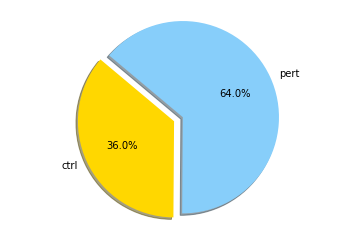

In [0]:
import matplotlib.pyplot as plt

# Data to plot
labels = 'ctrl', 'pert'
sizes = [36, 64]
colors = ['gold','lightskyblue']
explode = (0.1, 0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

# Combining Title + Description + source_name + characteristics

In [0]:
# wordnet_lemmatizer = WordNetLemmatizer()

# stop_words = set(stopwords.words('english')) 



# x = df_ctrl['total'].values
# x_proc = []
# pattern_to_find1 = "[^a-zA-Z0-9- ]"
# pattern_to_repl1 = " "
# pattern_to_find2 = "[^a-zA-Z ]";
# pattern_to_repl2 = ""

# preprocessed_text = []
# total_string_labels = ''

# for sample in x:
#     try:
#         pre_txt = re.sub(pattern_to_find1, pattern_to_repl1, sample)
#         pre_txt = re.sub(pattern_to_find2, pattern_to_repl2, pre_txt).lower()
#         pre_txt = re.sub(' +', ' ',pre_txt)
#         pre_txt = pre_txt.replace("ctrl", "control")
#         total_string_labels+=pre_txt
#         pre_proc_ver = ' '.join(wordnet_lemmatizer.lemmatize(w) for w in pre_txt.split() if w not in stop_words and len(w)>1)
#         x_proc.append(' '.join(w for w in pre_proc_ver.split() if w not in stop_words and len(w)>1))
#     #     print(pre_txt.strip())
#         preprocessed_text.extend([w for w in pre_proc_ver.split() if w not in stop_words and len(w)>1])
# #         preprocessed_text.extend(pre_txt.strip().split())
#     except:
#         continue    
        
# # print(preprocessed_text)        
# counts = Counter(preprocessed_text)
# print('Total Distinct Words in the combined text: ' + str(len(counts)))

In [0]:
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from collections import defaultdict
# nltk.download('averaged_perceptron_tagger')

# tag_map = defaultdict(lambda : wn.NOUN)
# tag_map['J'] = wn.ADJ
# tag_map['V'] = wn.VERB
# tag_map['R'] = wn.ADV
wordnet_lemmatizer = WordNetLemmatizer()

stop_words = set(stopwords.words('english')) 



x = df_ctrl['total'].values
x_proc = []
pattern_to_find1 = "[^a-zA-Z0-9- ]"
pattern_to_repl1 = " "
pattern_to_find2 = "[^a-zA-Z- ]";
pattern_to_repl2 = ""

preprocessed_text = []
total_string_labels = ''

for sample in x:
    try:
        pre_txt = re.sub(pattern_to_find1, pattern_to_repl1, sample)
        pre_txt = re.sub(pattern_to_find2, pattern_to_repl2, pre_txt).lower()
        
        pre_txt = pre_txt.replace("ctrl", "control")
        pre_txt = pre_txt.replace("contol", "control")
        pre_txt = pre_txt.replace("non ", "non")
        pre_txt = pre_txt.replace("non-", "non")
        
        pre_txt = pre_txt.replace("-", " ")
        pre_txt = re.sub(' +', ' ',pre_txt)
        

        total_string_labels+=pre_txt
        pre_proc_ver = ' '.join(wordnet_lemmatizer.lemmatize(token) for token in pre_txt.split() if token not in stop_words and len(token)>1)
        x_proc.append(pre_proc_ver)
    #     print(pre_txt.strip())
        preprocessed_text.extend([w for w in pre_proc_ver.split() if w not in stop_words and len(w)>1])
#         preprocessed_text.extend(pre_txt.strip().split())
    except:
        continue    
        
# print(preprocessed_text)        
counts = Counter(preprocessed_text)
print('Total Distinct Words in the combined text: ' + str(len(counts)))

Total Distinct Words in the combined text: 13725


In [0]:
def cnt_in_count(x):
    xx = counts.values()
    cnt = 0
    for i in xx:
        if i >= x:
            cnt+=1
    return cnt
print('Total No of words having count/Freq > 10: '+ str(cnt_in_count(10)))
print('Total No of words having count/Freq > 50: '+ str(cnt_in_count(50)))
print('Total No of words having count/Freq > 100: '+ str(cnt_in_count(100)))
print('Total No of words having count/Freq > 1000: '+ str(cnt_in_count(1000)))
print('Total No of words having count/Freq > 5000: '+ str(cnt_in_count(5000)))
print('Total No of words having count/Freq > 10000: '+ str(cnt_in_count(10000)))
print('Total No of words having count/Freq > 50000: '+ str(cnt_in_count(50000)))


Total No of words having count/Freq > 10: 8946
Total No of words having count/Freq > 50: 3580
Total No of words having count/Freq > 100: 2181
Total No of words having count/Freq > 1000: 260
Total No of words having count/Freq > 5000: 85
Total No of words having count/Freq > 10000: 61
Total No of words having count/Freq > 50000: 1


In [0]:
df_s = pd.DataFrame({'X':x_proc,'Y':df_ctrl['ctrl'].values})

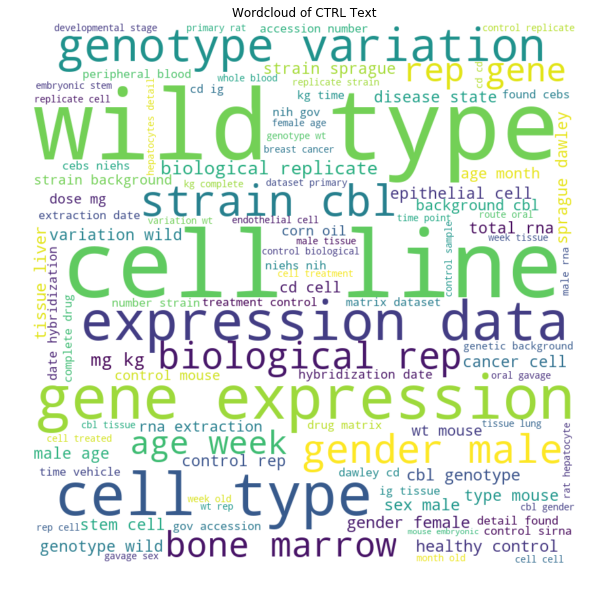

In [0]:
ctrl_sent = " ".join(sample for sample in df_s[df_s["Y"]==1].X)
pert_sent = " ".join(sample for sample in df_s[df_s["Y"]==0].X)


# wordcloud = WordCloud().generate(total_string_labels) 
wordcloud =  WordCloud(width = 800, height = 800,background_color="white", 
                 max_words=100,
                min_font_size = 10).generate(ctrl_sent)

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis("off") 
plt.title("Wordcloud of CTRL Text")
plt.tight_layout(pad = 0)

plt.show()



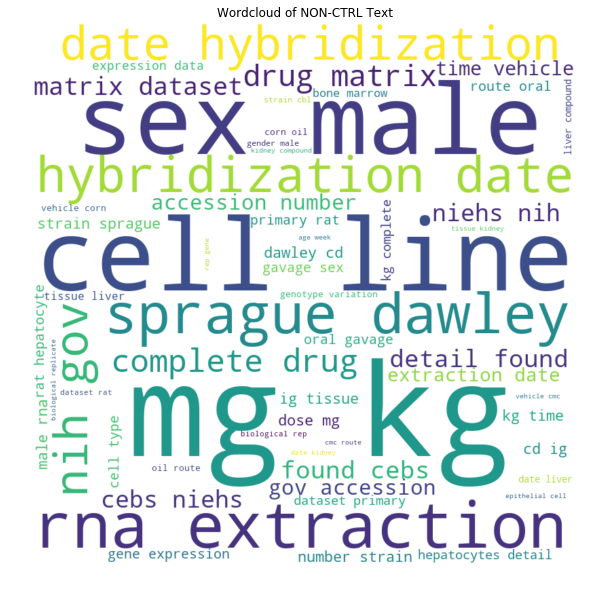

In [0]:
wordcloud =  WordCloud(width = 800, height = 800,background_color="white", 
                 max_words=100,
                min_font_size = 10).generate(pert_sent)

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis("off") 
plt.title("Wordcloud of NON-CTRL Text")
plt.tight_layout(pad = 0)

plt.show()

# ML Models on this Preprocessed Data

In [0]:
X_train, X_test, y_train, y_test = train_test_split(x_proc, df_ctrl['ctrl'].values, test_size=0.2)
nltk.download('punkt')
vectorizer = TfidfVectorizer(analyzer="word", tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english', max_features=10000)
train_vect = vectorizer.fit_transform(X_train)
test_vect = vectorizer.transform(X_test)
features = vectorizer.get_feature_names()
# print('features used by TF-IDF: '+ str(features))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
with open('Top_50_tfidf.txt','r') as f:
    print(f.read())

## All Predictive Models at a Single Place (used 5 fold cross validation)

In [0]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
nltk.download('punkt')
df = pd.DataFrame({'X':x_proc,'Y':df_ctrl['ctrl'].values})
X = df['X']
y = df['Y']

cv = ShuffleSplit(n_splits=5, test_size=0.2)
vect = TfidfVectorizer(analyzer="word", tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english', max_features=10000)

# Models Used
models = [
    MultinomialNB(),
    BernoulliNB(),
    LogisticRegression(),
    SGDClassifier(),
    LinearSVC(),
    RandomForestClassifier(),
    KNeighborsClassifier(n_neighbors=5),
    xgboost.XGBClassifier()
]


# Init a dictionary for storing results of each run for each model
results = {
    model.__class__.__name__: {
        'accuracy': [], 
        'f1_score': [],
        'confusion_matrix': []
    } for model in models
}

results = {
    model.__class__.__name__: {
        'accuracy': [], 
        'f1_score': [],
        'confusion_matrix': [],
        'test_accuracy': [], 
        'test_f1_score': [],
        'test_confusion_matrix': [],
    } for model in models
}

cnt = 0
for train_index, test_index in cv.split(X):
    cnt+=1
    X_train, X_test  = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    X_train_vect = vect.fit_transform(X_train)    
    X_test_vect = vect.transform(X_test)
    
    t = 0
    for model in models:
        t+=1
        model.fit(X_train_vect, y_train)
        y_pred = model.predict(X_test_vect)
        
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        
        results[model.__class__.__name__]['accuracy'].append(acc)
        results[model.__class__.__name__]['f1_score'].append(f1)
        results[model.__class__.__name__]['confusion_matrix'].append(cm)
        
for model, d in results.items():
    avg_acc = sum(d['accuracy']) / len(d['accuracy']) * 100
    avg_f1 = sum(d['f1_score']) / len(d['f1_score']) * 100
    avg_cm = sum(d['confusion_matrix']) / len(d['confusion_matrix'])
    
    slashes = '-' * 30
    
    s = f"""{model}\n{slashes}
        Avg. Accuracy: {avg_acc:.2f}%
        Avg. F1 Score: {avg_f1:.2f}
        Avg. Confusion Matrix: 
        \n{avg_cm}
        """
    print(s)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to sile

MultinomialNB
------------------------------
        Avg. Accuracy: 84.85%
        Avg. F1 Score: 80.70
        Avg. Confusion Matrix: 
        
[[8300.2 1688.8]
 [ 676.8 4947.2]]
        
BernoulliNB
------------------------------
        Avg. Accuracy: 58.25%
        Avg. F1 Score: 62.07
        Avg. Confusion Matrix: 
        
[[3761.  6228. ]
 [ 291.2 5332.8]]
        
LogisticRegression
------------------------------
        Avg. Accuracy: 94.62%
        Avg. F1 Score: 92.30
        Avg. Confusion Matrix: 
        
[[9739.8  249.2]
 [ 590.6 5033.4]]
        
SGDClassifier
------------------------------
        Avg. Accuracy: 93.31%
        Avg. F1 Score: 90.33
        Avg. Confusion Matrix: 
        
[[9692.4  296.6]
 [ 747.2 4876.8]]
        
LinearSVC
------------------------------
        Avg. Accuracy: 96.47%
        Avg. F1 Score: 95.04
        Avg. Confusion Matrix: 
        
[[9774.4  214.6]
 [ 337.2 5286.8]]
        
RandomForestClassifier
------------------------------
  

## Logistic  Model Interpretations

In [0]:
nltk.download('punkt')
df = pd.DataFrame({'X':x_proc,'Y':df_ctrl['ctrl'].values})
# print(df.head(5))
X = df['X']
y = df['Y']

ss = ShuffleSplit(n_splits=1, test_size=0.2)

accs = []
f1s = []
cms = []

vect = TfidfVectorizer(analyzer="word", tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english', max_features=10000)

nb = LogisticRegression()

list1,list2=[],[]
for train_index, test_index in ss.split(X):
#     print(train_index)
#     print(test_index)
    
    X_train, X_test  = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit vectorizer and transform X train, then transform X test
    X_train_vect = vect.fit_transform(X_train)
    X_test_vect = vect.transform(X_test)
    
    # Oversample
#     X_train_res, y_train_res = sm.fit_sample(X_train_vect, y_train)
    
    # Fit Naive Bayes on the vectorized X with y train labels, 
    # then predict new y labels using X test
    nb.fit(X_train_vect, y_train)
    y_pred = nb.predict(X_test_vect)
    
    # Determine test set accuracy and f1 score on this fold using the true y labels and predicted y labels
    accs.append(accuracy_score(y_test, y_pred))
    f1s.append(f1_score(y_test, y_pred))
    cms.append(confusion_matrix(y_test, y_pred))
    
    anal = dict(zip(vect.get_feature_names(), nb.coef_[0]))
    sort_anal = sorted(anal.items(), key=operator.itemgetter(1))

    rev_anal = sorted(anal.items(), key=operator.itemgetter(1),reverse =True)
    # print(anal)

    print('\n\nTop words contributes to CTRL: ')
    for key,value in rev_anal[:20]:
        print((key,value))
        list1.append(key)

    print('\n\nTop words contributes to PERT: ')
    for key,value in sort_anal[:20]:
        print((key,value))
        list2.append(key)

print("\nAverage accuracy across folds: {:.2f}%".format(sum(accs) / len(accs) * 100))
print("\nAverage F1 score across folds: {:.2f}%".format(sum(f1s) / len(f1s) * 100))
print("\nAverage Confusion Matrix across folds: \n {}".format(sum(cms) / len(cms)))


# anal = dict(zip(vect.get_feature_names(), nb.coef_[0]))
# sort_anal = sorted(anal.items(), key=operator.itemgetter(1))

# rev_anal = sorted(anal.items(), key=operator.itemgetter(1),reverse =True)
# print(anal)

# print('\n\nTop words contributes to CTRL: ')
# for key,value in rev_anal[:20]:
#     print((key,value))

# print('\n\nTop words contributes to PERT: ')
# for key,value in sort_anal[:20]:
#     print((key,value))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)




Top words contributes to CTRL: 
('control', 24.729796395550068)
('wt', 16.164311043210926)
('wild', 12.647258491804116)
('wildtype', 12.319820682850029)
('vehicle', 12.125674483614283)
('normal', 11.313711837301321)
('cmc', 11.233832930911385)
('dmso', 10.744825925159246)
('saline', 10.640622584718116)
('water', 9.51056439780495)
('untreated', 8.084521395720445)
('oil', 6.9362276059424985)
('healthy', 6.528859023494774)
('corn', 6.374340622029312)
('scrambled', 6.05452113980412)
('sicontrol', 5.318272898998941)
('mock', 5.311763007813832)
('pretreatment', 5.171832307333626)
('vector', 4.987893414286527)
('ctr', 4.934171474425626)


Top words contributes to PERT: 
('compound', -16.05310189581721)
('ko', -8.36205649549619)
('knockout', -5.794058591461909)
('um', -5.663315669863569)
('nhbe', -4.441529432150889)
('transgenic', -4.3489533571763195)
('mutant', -4.081672657984734)
('md', -3.735900046929468)
('wy', -3.5682537704186763)
('treated', -3.5610854510326555)
('mir', -3.466098407268

In [0]:
mapping = dict(zip(vect.get_feature_names(),nb.coef_[0]))
idf = dict(zip(vect.get_feature_names(),vect.idf_))
# print(mapping['pert'])
# : control
print(mapping['hsf'],mapping['control'])
print(idf['hsf'],idf['control'])

print(mapping['knockdown'],idf['knockdown'])

-0.8769319793789208 24.729796395550068
8.328533435910963 2.7290280531879745
-1.9330695088089493 5.309894796148063


In [0]:
print(set(list1))
print(set(list2))

{'sham', 'wild', 'placebo', 'sicontrol', 'healthy', 'mock', 'saline', 'normal', 'cmc', 'untreated', 'scrambled', 'wildtype', 'control', 'pretreatment', 'oil', 'vector', 'vehicle', 'water', 'corn', 'wt', 'dmso'}
{'deficient', 'cisplatin', 'compound', 'mpn', 'nhbe', 'mutant', 'ko', 'pdei', 'timepoints', 'cie', 'md', 'cko', 'ifn', 'knockout', 'induced', 'recur', 'wy', 'mir', 'null', 'um', 'overexpressor', 'transgenic', 'autism', 'shae', 'sars', 'mut', 'treated'}


## Random Forest Interpretations

In [0]:
df = pd.DataFrame({'X':x_proc,'Y':df_ctrl['ctrl'].values})
# print(df.head(5))
X = df['X']
y = df['Y']

ss = ShuffleSplit(n_splits=10, test_size=0.2)

accs = []
f1s = []
cms = []

vect = TfidfVectorizer(analyzer="word", tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english', max_features=10000)

nb = RandomForestClassifier()

for train_index, test_index in ss.split(X):
#     print(train_index)
#     print(test_index)
    
    X_train, X_test  = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit vectorizer and transform X train, then transform X test
    X_train_vect = vect.fit_transform(X_train)
    X_test_vect = vect.transform(X_test)
    
    # Oversample
#     X_train_res, y_train_res = sm.fit_sample(X_train_vect, y_train)
    
    # Fit Naive Bayes on the vectorized X with y train labels, 
    # then predict new y labels using X test
    nb.fit(X_train_vect, y_train)
    y_pred = nb.predict(X_test_vect)
    
    # Determine test set accuracy and f1 score on this fold using the true y labels and predicted y labels
    accs.append(accuracy_score(y_test, y_pred))
    f1s.append(f1_score(y_test, y_pred))
    cms.append(confusion_matrix(y_test, y_pred))
    
print("\nAverage accuracy across folds: {:.2f}%".format(sum(accs) / len(accs) * 100))
print("\nAverage F1 score across folds: {:.2f}%".format(sum(f1s) / len(f1s) * 100))
print("\nAverage Confusion Matrix across folds: \n {}".format(sum(cms) / len(cms)))


anal = dict(zip(vect.get_feature_names(), nb.feature_importances_))
sort_anal = sorted(anal.items(), key=operator.itemgetter(1))

rev_anal = sorted(anal.items(), key=operator.itemgetter(1),reverse =True)
# print(anal)

print('\n\nTop words contributes to CTRL: ')
for key,value in rev_anal[:10]:
    print((key,value))



## Voting Classifier of 8 Models

In [0]:

nltk.download('punkt')
df = pd.DataFrame({'X':x_proc,'Y':df_ctrl['ctrl'].values})
X = df['X']
y = df['Y']

cv = ShuffleSplit(n_splits=5, test_size=0.2)
vect = TfidfVectorizer(analyzer="word", tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english', max_features=10000)
model_names = ['MultinomialNB','BernouliNB','logistic','sgd classifier','SVM','Random forest','KNN','XGboost']
md = [
    MultinomialNB(),
    BernoulliNB(),
    LogisticRegression(),
    SGDClassifier(),
    LinearSVC(),
    RandomForestClassifier(),
    KNeighborsClassifier(n_neighbors=5),
    xgboost.XGBClassifier()
]
# Models Used
models = [
    MultinomialNB(),
    BernoulliNB(),
    LogisticRegression(),
    SGDClassifier(),
    LinearSVC(),
    RandomForestClassifier(),
    KNeighborsClassifier(n_neighbors=5),
    xgboost.XGBClassifier(),
    VotingClassifier([(c1,c2) for c1,c2 in zip(model_names,md)])
]


# Init a dictionary for storing results of each run for each model
results = {
    model.__class__.__name__: {
        'accuracy': [], 
        'f1_score': [],
        'confusion_matrix': []
    } for model in models
}
cnt = 0
for train_index, test_index in cv.split(X):
    cnt+=1
    X_train, X_test  = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    X_train_vect = vect.fit_transform(X_train)    
    X_test_vect = vect.transform(X_test)
    
    t = 0
    estimators = []
    for model in models:
        
        t+=1
        model.fit(X_train_vect, y_train)
        y_pred = model.predict(X_test_vect)
        
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        
        results[model.__class__.__name__]['accuracy'].append(acc)
        results[model.__class__.__name__]['f1_score'].append(f1)
        results[model.__class__.__name__]['confusion_matrix'].append(cm)
        
#     ensemble = VotingClassifier(estimators)
#     ensemble.fit(X_train_vect, y_train)
#     y_pred = model.predict(X_test_vect)
#     acc = accuracy_score(y_test, y_pred)
#     f1 = f1_score(y_test, y_pred)
#     cm = confusion_matrix(y_test, y_pred)
    
#     print(acc,f1)
#     print(cm)
#     model = models[8]
#     results[model.__class__.__name__]['accuracy'].append(acc)
#     results[model.__class__.__name__]['f1_score'].append(f1)
#     results[model.__class__.__name__]['confusion_matrix'].append(cm)

for model, d in results.items():
    avg_acc = sum(d['accuracy']) / len(d['accuracy']) * 100
    avg_f1 = sum(d['f1_score']) / len(d['f1_score']) * 100
    avg_cm = sum(d['confusion_matrix']) / len(d['confusion_matrix'])
    
    slashes = '-' * 30
    
    s = f"""{model}\n{slashes}
        Avg. Accuracy: {avg_acc:.2f}%
        Avg. F1 Score: {avg_f1:.2f}
        Avg. Confusion Matrix: 
        \n{avg_cm}
        """
    print(s)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22.

MultinomialNB
------------------------------
        Avg. Accuracy: 85.04%
        Avg. F1 Score: 80.80
        Avg. Confusion Matrix: 
        
[[8359.6 1654.8]
 [ 681.6 4917. ]]
        
BernoulliNB
------------------------------
        Avg. Accuracy: 58.53%
        Avg. F1 Score: 62.08
        Avg. Confusion Matrix: 
        
[[3838.2 6176.2]
 [ 298.6 5300. ]]
        
LogisticRegression
------------------------------
        Avg. Accuracy: 94.78%
        Avg. F1 Score: 92.48
        Avg. Confusion Matrix: 
        
[[9787.8  226.6]
 [ 588.2 5010.4]]
        
SGDClassifier
------------------------------
        Avg. Accuracy: 93.35%
        Avg. F1 Score: 90.32
        Avg. Confusion Matrix: 
        
[[9729.   285.4]
 [ 752.6 4846. ]]
        
LinearSVC
------------------------------
        Avg. Accuracy: 96.72%
        Avg. F1 Score: 95.38
        Avg. Confusion Matrix: 
        
[[9826.6  187.8]
 [ 323.6 5275. ]]
        
RandomForestClassifier
------------------------------
  

## Applied Model in the Paper

In [0]:
from sklearn.ensemble import BaggingClassifier
nltk.download('punkt')

df = pd.DataFrame({'X':x_proc,'Y':df_ctrl['ctrl'].values})
X = df['X']
y = df['Y']

cv = ShuffleSplit(n_splits=10, test_size=0.1)
vect = TfidfVectorizer(analyzer="word", tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english', max_features=10000)

# Models Used
models = [BaggingClassifier(base_estimator=MultinomialNB(), n_estimators=20, random_state=42)]


# Init a dictionary for storing results of each run for each model
results = {
    model.__class__.__name__: {
        'accuracy': [], 
        'f1_score': [],
        'confusion_matrix': []
    } for model in models
}
cnt = 0
for train_index, test_index in cv.split(X):
    cnt+=1
    X_train, X_test  = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    X_train_vect = vect.fit_transform(X_train)    
    X_test_vect = vect.transform(X_test)

    t = 0
    for model in models:
        t+=1
        model.fit(X_train_vect, y_train)
        y_pred = model.predict(X_test_vect)

        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)

        results[model.__class__.__name__]['accuracy'].append(acc)
        results[model.__class__.__name__]['f1_score'].append(f1)
        results[model.__class__.__name__]['confusion_matrix'].append(cm)

for model, d in results.items():
    avg_acc = sum(d['accuracy']) / len(d['accuracy']) * 100
    avg_f1 = sum(d['f1_score']) / len(d['f1_score']) * 100
    avg_cm = sum(d['confusion_matrix']) / len(d['confusion_matrix'])

    slashes = '-' * 30

    s = f"""{model}\n{slashes}
        Avg. Accuracy: {avg_acc:.2f}%
        Avg. F1 Score: {avg_f1:.2f}
        Avg. Confusion Matrix: 
        \n{avg_cm}
        """
    print(s)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
BaggingClassifier
------------------------------
        Avg. Accuracy: 85.19%
        Avg. F1 Score: 80.95
        Avg. Confusion Matrix: 
        
[[4193.2  818.1]
 [ 338.2 2457.5]]
        


In [0]:
# for i in range(0,20):
#     nb = models[0].estimators_[i]
#     print(nb.coef_)
#     anal = dict(zip(vect.get_feature_names(), nb.feature_log_prob_[1]))
#     anall = dict(zip(vect.get_feature_names(), nb.feature_log_prob_[0]))
#     sort_anal = sorted(anal.items(), key=operator.itemgetter(1),reverse=True)

#     rev_anal = sorted(anall.items(), key=operator.itemgetter(1),reverse=True)
#     # print(anal)

#     print('\n\nTop words contributes to CTRL: ')
#     for key,value in sort_anal[:10]:
#         print((key,value))

#     print('\n\nTop words contributes to PERT: ')
#     for key,value in rev_anal[:10]:
#         print((key,value))  
for i in range(0,2):
    nb = models[0].estimators_[i]      
    index = 0
    coef_features_c1_c2 = []

    for feat, c1, c2 in zip(vect.get_feature_names(), nb.feature_count_[0], nb.feature_count_[1]):
        coef_features_c1_c2.append(tuple([nb.coef_[0][index], feat, c1, c2,index]))
        index+=1

    for i in sorted(coef_features_c1_c2)[-10:]:
        print(i)
    print("----------------------------------------")

(-4.998883788446048, 'line', 814.5499659788202, 636.1589067172796, 4925)
(-4.993781766816024, 'genotype', 600.8060430174409, 639.4180121846982, 3372)
(-4.9725281160348365, 'liver', 1676.9195732630965, 653.1749072425326, 4959)
(-4.796441237795704, 'tissue', 1298.1658945439792, 779.1308298589973, 9137)
(-4.760243553521256, 'mouse', 818.1657835200532, 807.887074251292, 5697)
(-4.536603074861293, 'wild', 82.43801731700185, 1010.6114153083089, 9818)
(-4.439209728542211, 'type', 696.28901826685, 1114.0930635298346, 9436)
(-4.297693926684554, 'wt', 122.41646478858738, 1283.6080705175948, 9858)
(-4.03403543279314, 'cell', 2181.8535725995644, 1671.15324175037, 1344)
(-3.753815956873088, 'control', 137.003100652252, 2211.9614434105156, 1751)
----------------------------------------
(-5.0108819017913975, 'genotype', 596.607179217976, 631.48596307789, 3372)
(-4.97810367593439, 'line', 824.859974362715, 652.5612491422966, 4925)
(-4.949392365836001, 'liver', 1725.6658183005163, 671.5978236329665, 49

# ON TEST DATASET

In [0]:
df1 = pd.read_csv('drug.csv')
df1 = df1.dropna(subset=['Ctrl']) 
print('columns:',end=' ')
print(df1.columns.values)
print('No of Data Points: ' + str(len(df1)))

df2 = pd.read_csv('disease.csv')
df2 = df2.dropna(subset=['Ctrl']) 
print('columns:',end=' ')
print(df2.columns.values)
print('No of Data Points: ' + str(len(df2)))

df3 = pd.read_csv('gene.csv')
df3 = df3.dropna(subset=['Ctrl']) 
print('columns:',end=' ')
print(df3.columns.values)
print('No of Data Points: ' + str(len(df3)))

df_test = pd.concat([df1,df2,df3])
print('columns:',end=' ')
print(df_test.columns.values)
print('No of Data Points: ' + str(len(df_test)))
# df_ctrl = df_ctrl.replace(np.nan, '', regex=True)

# df_ctrl['total'] = df_ctrl['title'].str.cat(' '+ df_ctrl['description'].str.cat(' '+ df_ctrl['characteristics_ch1'].str.cat(' '+ df_ctrl['source_name_ch1'])))
# df_ctrl['total']  = df_ctrl['total'].replace('\s+', ' ', regex=True)
# df_ctrl.to_csv('creeds_control_data.csv',index=False)

df_test = df_test.replace(np.nan, '', regex=True)
df_test['total'] = df_test['title'].str.cat(' '+ df_test['description'].str.cat(' '+ df_test['characteristics_ch1'].str.cat(' '+ df_test['source_name_ch1'])))
df_test['total']  = df_test['total'].replace('\s+', ' ', regex=True)
df_test.to_csv('test_data.csv',index=False)

columns: ['sample_id' 'gse_id' 'title' 'source_name_ch1' 'characteristics_ch1'
 'description' 'Ctrl' 'Pert']
No of Data Points: 3666
columns: ['sample_id' 'gse_id' 'title' 'source_name_ch1' 'characteristics_ch1'
 'description' 'Ctrl' 'Pert']
No of Data Points: 4291
columns: ['sample_id' 'gse_id' 'title' 'source_name_ch1' 'characteristics_ch1'
 'description' 'Ctrl' 'Pert']
No of Data Points: 3281
columns: ['sample_id' 'gse_id' 'title' 'source_name_ch1' 'characteristics_ch1'
 'description' 'Ctrl' 'Pert']
No of Data Points: 11238


In [0]:
df_test["Ctrl"] = df_test["Ctrl"].fillna(0.0).astype(int)


In [0]:
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from collections import defaultdict
# nltk.download('averaged_perceptron_tagger')

# tag_map = defaultdict(lambda : wn.NOUN)
# tag_map['J'] = wn.ADJ
# tag_map['V'] = wn.VERB
# tag_map['R'] = wn.ADV
wordnet_lemm = WordNetLemmatizer()

stop_words = set(stopwords.words('english')) 


x = df_test['total'].values
test_proc = []
pattern_to_find1 = "[^a-zA-Z0-9- ]"
pattern_to_repl1 = " "
pattern_to_find2 = "[^a-zA-Z- ]";
pattern_to_repl2 = ""
test_preprocessed_text = []
total_string_labels = ''

for sample in x:
    try:
        pre_txt = re.sub(pattern_to_find1, pattern_to_repl1, sample)
        pre_txt = re.sub(pattern_to_find2, pattern_to_repl2, pre_txt).lower()
       
        pre_txt = pre_txt.replace("ctrl", "control")
        pre_txt = pre_txt.replace("contol", "control")
        pre_txt = pre_txt.replace("non ", "non")
        pre_txt = pre_txt.replace("non-", "non")
        
        pre_txt = pre_txt.replace("-", " ")
        pre_txt = re.sub(' +', ' ',pre_txt)
        
       
        total_string_labels+=pre_txt
        pre_proc_ver = ' '.join(wordnet_lemm.lemmatize(w) for w in pre_txt.split() if w not in stop_words and len(w)>1)
        
        test_proc.append(pre_proc_ver)
        
        test_preprocessed_text.extend([w for w in pre_proc_ver.split() if w not in stop_words and len(w)>1])
#         preprocessed_text.extend(pre_txt.strip().split())
    except:
        continue    
# print(preprocessed_text)        
counts = Counter(test_preprocessed_text)
print('Total Distinct Words in the combined text: ' + str(len(counts)))

Total Distinct Words in the combined text: 2177


## All Models

In [0]:
nltk.download('punkt')
df = pd.DataFrame({'X':x_proc,'Y':df_ctrl['ctrl'].values})
X = df['X']
y = df['Y']
X_t = test_proc
y_t = df_test['Ctrl'].values

cv = ShuffleSplit(n_splits=5, test_size=0.2)
vect = TfidfVectorizer(analyzer="word", 
    preprocessor=None, stop_words='english', max_features=10000)
# max_features=10000 ngram_range = (1,3)
# Models Used
models = [
    MultinomialNB(),
    BernoulliNB(),
    LogisticRegression(),
    SGDClassifier(),
    LinearSVC(),
    RandomForestClassifier(),
    KNeighborsClassifier(n_neighbors=5),
    xgboost.XGBClassifier()
]


# Init a dictionary for storing results of each run for each model

results = {
    model.__class__.__name__: {
        'accuracy': [], 
        'f1_score': [],
        'confusion_matrix': [],
        'test_accuracy': [], 
        'test_f1_score': [],
        'test_confusion_matrix': [],
    } for model in models
}

pred = []

cnt = 0
for train_index, test_index in cv.split(X):
    cnt+=1
    X_train, X_test  = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    X_train_vect = vect.fit_transform(X_train)    
    X_test_vect = vect.transform(X_test)
    
    X_t_vect = vect.transform(X_t)
    t = 0
    for model in models:
        t+=1
        model.fit(X_train_vect, y_train)
        y_pred = model.predict(X_test_vect)
        y_t_pred = model.predict(X_t_vect)
        pred.append(y_t_pred)
        
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        
        acc_t = accuracy_score(y_t, y_t_pred)
        f1_t = f1_score(y_t, y_t_pred)
        cm_t = confusion_matrix(y_t, y_t_pred)
        
        
        results[model.__class__.__name__]['accuracy'].append(acc)
        results[model.__class__.__name__]['f1_score'].append(f1)
        results[model.__class__.__name__]['confusion_matrix'].append(cm)
        results[model.__class__.__name__]['test_accuracy'].append(acc_t)
        results[model.__class__.__name__]['test_f1_score'].append(f1_t)
        results[model.__class__.__name__]['test_confusion_matrix'].append(cm_t)
        
for model, d in results.items():
    avg_acc = sum(d['accuracy']) / len(d['accuracy']) * 100
    avg_f1 = sum(d['f1_score']) / len(d['f1_score']) * 100
    avg_cm = sum(d['confusion_matrix']) / len(d['confusion_matrix'])
    
    avg_acc_t = sum(d['test_accuracy']) / len(d['test_accuracy']) * 100
    avg_f1_t = sum(d['test_f1_score']) / len(d['test_f1_score']) * 100
    avg_cm_t = sum(d['test_confusion_matrix']) / len(d['test_confusion_matrix'])
    
    slashes = '-' * 30
    
    s = f"""{model}\n{slashes}
        Avg. Accuracy: {avg_acc:.2f}%
        Avg. F1 Score: {avg_f1:.2f}
        Avg. Confusion Matrix: 
        \n{avg_cm}
        Avg. Test Accuracy: {avg_acc_t:.2f}%
        Avg. Test F1 Score: {avg_f1_t:.2f}
        Avg. Test Confusion Matrix: 
        \n{avg_cm_t}
        """
    print(s)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to sile

MultinomialNB
------------------------------
        Avg. Accuracy: 85.10%
        Avg. F1 Score: 80.82
        Avg. Confusion Matrix: 
        
[[8386.6 1636.6]
 [ 689.4 4900.4]]
        Avg. Test Accuracy: 76.70%
        Avg. Test F1 Score: 72.52
        Avg. Test Confusion Matrix: 
        
[[5161.4 1764.6]
 [ 853.8 3458.2]]
        
BernoulliNB
------------------------------
        Avg. Accuracy: 58.47%
        Avg. F1 Score: 61.97
        Avg. Confusion Matrix: 
        
[[3844.2 6179. ]
 [ 305.8 5284. ]]
        Avg. Test Accuracy: 46.78%
        Avg. Test F1 Score: 58.99
        Avg. Test Confusion Matrix: 
        
[[ 954.8 5971.2]
 [  10.  4302. ]]
        
LogisticRegression
------------------------------
        Avg. Accuracy: 94.77%
        Avg. F1 Score: 92.46
        Avg. Confusion Matrix: 
        
[[9793.6  229.6]
 [ 587.  5002.8]]
        Avg. Test Accuracy: 88.22%
        Avg. Test F1 Score: 83.78
        Avg. Test Confusion Matrix: 
        
[[6496.4  429.6]
 [ 893.

In [0]:
print(len(pred))
print(pred[2])
df_test['Logistic'] = pred[2]
df_test.to_csv('predicted_data.csv',index=False)

8
[1 0 1 ... 0 0 0]


In [0]:
df_wrong = df_test[df_test['Logistic'] != df_test['Ctrl']]
print(len(df_wrong))

df_wrong.to_csv('wrongly_predicted_data.csv',index=False)

194


### Bagging - Applied in the paper

In [0]:
from sklearn.ensemble import BaggingClassifier

nltk.download('punkt')
df = pd.DataFrame({'X':x_proc,'Y':df_ctrl['ctrl'].values})
X = df['X']
y = df['Y']
X_t = test_proc
y_t = df_test['Ctrl'].values
cv = ShuffleSplit(n_splits=10, test_size=0.1)
vect = TfidfVectorizer(analyzer="word", tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english', max_features=10000)

# Models Used
models = [BaggingClassifier(base_estimator=MultinomialNB(), n_estimators=20, random_state=42)]

results = {
    model.__class__.__name__: {
        'accuracy': [], 
        'f1_score': [],
        'confusion_matrix': [],
        'test_accuracy': [], 
        'test_f1_score': [],
        'test_confusion_matrix': [],
    } for model in models
}

cnt = 0
for train_index, test_index in cv.split(X):
    cnt+=1
    X_train, X_test  = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    X_train_vect = vect.fit_transform(X_train)    
    X_test_vect = vect.transform(X_test)
    
    X_t_vect = vect.transform(X_t)
    t = 0
    for model in models:
        t+=1
        model.fit(X_train_vect, y_train)
        y_pred = model.predict(X_test_vect)
        y_t_pred = model.predict(X_t_vect)
        
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        
        acc_t = accuracy_score(y_t, y_t_pred)
        f1_t = f1_score(y_t, y_t_pred)
        cm_t = confusion_matrix(y_t, y_t_pred)
        
        
        results[model.__class__.__name__]['accuracy'].append(acc)
        results[model.__class__.__name__]['f1_score'].append(f1)
        results[model.__class__.__name__]['confusion_matrix'].append(cm)
        results[model.__class__.__name__]['test_accuracy'].append(acc_t)
        results[model.__class__.__name__]['test_f1_score'].append(f1_t)
        results[model.__class__.__name__]['test_confusion_matrix'].append(cm_t)
        
for model, d in results.items():
    avg_acc = sum(d['accuracy']) / len(d['accuracy']) * 100
    avg_f1 = sum(d['f1_score']) / len(d['f1_score']) * 100
    avg_cm = sum(d['confusion_matrix']) / len(d['confusion_matrix'])
    
    avg_acc_t = sum(d['test_accuracy']) / len(d['test_accuracy']) * 100
    avg_f1_t = sum(d['test_f1_score']) / len(d['test_f1_score']) * 100
    avg_cm_t = sum(d['test_confusion_matrix']) / len(d['test_confusion_matrix'])
    
    slashes = '-' * 30
    
    s = f"""{model}\n{slashes}
        Avg. Accuracy: {avg_acc:.2f}%
        Avg. F1 Score: {avg_f1:.2f}
        Avg. Confusion Matrix: 
        \n{avg_cm}
        Avg. Test Accuracy: {avg_acc_t:.2f}%
        Avg. Test F1 Score: {avg_f1_t:.2f}
        Avg. Test Confusion Matrix: 
        \n{avg_cm_t}
        """
    print(s)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
BaggingClassifier
------------------------------
        Avg. Accuracy: 84.95%
        Avg. F1 Score: 80.69
        Avg. Confusion Matrix: 
        
[[4177.8  833.2]
 [ 341.5 2454.5]]
        Avg. Test Accuracy: 76.14%
        Avg. Test F1 Score: 72.04
        Avg. Test Confusion Matrix: 
        
[[5098.1 1827.9]
 [ 853.6 3458.4]]
        


### Voting Classifier

In [0]:
df = pd.DataFrame({'X':x_proc,'Y':df_ctrl['ctrl'].values})
X = df['X']
y = df['Y']
X_t = test_proc
y_t = df_test['Ctrl'].values

cv = ShuffleSplit(n_splits=5, test_size=0.2)
vect = TfidfVectorizer(analyzer="word", tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english', max_features=10000)
model_names = ['MultinomialNB','BernouliNB','logistic','sgd classifier','SVM','Random forest','KNN','XGboost']
md = [
    MultinomialNB(),
    BernoulliNB(),
    LogisticRegression(),
    SGDClassifier(),
    LinearSVC(),
    RandomForestClassifier(),
    KNeighborsClassifier(n_neighbors=5),
    xgboost.XGBClassifier()
]
# Models Used
models = [
    VotingClassifier([(c1,c2) for c1,c2 in zip(model_names,md)])
]


# Init a dictionary for storing results of each run for each model
results = {
    model.__class__.__name__: {
        'accuracy': [], 
        'f1_score': [],
        'confusion_matrix': [],
        'test_accuracy': [], 
        'test_f1_score': [],
        'test_confusion_matrix': [],
    } for model in models
}

cnt = 0
for train_index, test_index in cv.split(X):
    cnt+=1
    X_train, X_test  = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    X_train_vect = vect.fit_transform(X_train)    
    X_test_vect = vect.transform(X_test)
    
    X_t_vect = vect.transform(X_t)
    t = 0
    for model in models:
        t+=1
        model.fit(X_train_vect, y_train)
        y_pred = model.predict(X_test_vect)
        y_t_pred = model.predict(X_t_vect)
        
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        
        acc_t = accuracy_score(y_t, y_t_pred)
        f1_t = f1_score(y_t, y_t_pred)
        cm_t = confusion_matrix(y_t, y_t_pred)
        
        
        results[model.__class__.__name__]['accuracy'].append(acc)
        results[model.__class__.__name__]['f1_score'].append(f1)
        results[model.__class__.__name__]['confusion_matrix'].append(cm)
        results[model.__class__.__name__]['test_accuracy'].append(acc_t)
        results[model.__class__.__name__]['test_f1_score'].append(f1_t)
        results[model.__class__.__name__]['test_confusion_matrix'].append(cm_t)
        
for model, d in results.items():
    avg_acc = sum(d['accuracy']) / len(d['accuracy']) * 100
    avg_f1 = sum(d['f1_score']) / len(d['f1_score']) * 100
    avg_cm = sum(d['confusion_matrix']) / len(d['confusion_matrix'])
    
    avg_acc_t = sum(d['test_accuracy']) / len(d['test_accuracy']) * 100
    avg_f1_t = sum(d['test_f1_score']) / len(d['test_f1_score']) * 100
    avg_cm_t = sum(d['test_confusion_matrix']) / len(d['test_confusion_matrix'])
    
    slashes = '-' * 30
    
    s = f"""{model}\n{slashes}
        Avg. Accuracy: {avg_acc:.2f}%
        Avg. F1 Score: {avg_f1:.2f}
        Avg. Confusion Matrix: 
        \n{avg_cm}
        Avg. Test Accuracy: {avg_acc_t:.2f}%
        Avg. Test F1 Score: {avg_f1_t:.2f}
        Avg. Test Confusion Matrix: 
        \n{avg_cm_t}
        """
    print(s)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22.

VotingClassifier
------------------------------
        Avg. Accuracy: 95.91%
        Avg. F1 Score: 94.24
        Avg. Confusion Matrix: 
        
[[9748.6  223.2]
 [ 415.6 5225.6]]
        Avg. Test Accuracy: 88.98%
        Avg. Test F1 Score: 84.71
        Avg. Test Confusion Matrix: 
        
[[6569.6  356.4]
 [ 881.6 3430.4]]
        


In [0]:
# df_test = df_ctrl[df_ctrl['total'].str.contains("ef wt")]
# print(len(df_test))
# print(len(df_test[df_test['ctrl']==1]))


df = pd.DataFrame({'X':x_proc,'Y':df_ctrl['ctrl'].values})
df_test = df[df['X'].str.contains("nhbe")]
print(len(df_test))
print(len(df_test[df_test['Y']==1]))

60
3


## All Models on 9000 samples train and remaining test

In [0]:
import random
nltk.download('punkt')


vect = TfidfVectorizer(analyzer="word", 
    preprocessor=None, stop_words='english', max_features=10000)
# max_features=10000 ngram_range = (1,3)
# Models Used
models = [
    MultinomialNB(),
    BernoulliNB(),
    LogisticRegression(),
    SGDClassifier(),
    LinearSVC(),
    RandomForestClassifier(),
    KNeighborsClassifier(n_neighbors=5),
    xgboost.XGBClassifier()
]


# Init a dictionary for storing results of each run for each model

results = {
    model.__class__.__name__: {
        'accuracy': [], 
        'f1_score': [],
        'confusion_matrix': [],
        
    } for model in models
}

pred = []
for val in range(5):
    test_data = test_proc
    test_labels = df_test['Ctrl'].values.tolist()
    
    mapIndexPosition = list(zip(test_data, test_labels))
    random.shuffle(mapIndexPosition)
    test_data, test_labels = zip(*mapIndexPosition)
    
    print(len(test_data),len(test_labels))
    samp_proc = x_proc.copy()
    print(len(samp_proc))
    samp_proc.extend(test_data)
    labels = df_ctrl['ctrl'].values.tolist()
    labels.extend(test_labels)
    print(len(labels))
    print(len(samp_proc))
    
    df = pd.DataFrame({'X':samp_proc,'Y':labels})
    X = df['X']
    y = df['Y']

    

    X_train, X_test  = X[:88000], X[88000:]
    y_train, y_test = y[:88000], y[88000:]

    X_train_vect = vect.fit_transform(X_train)    
    X_test_vect = vect.transform(X_test)

    t = 0
    for model in models:
        t+=1
        model.fit(X_train_vect, y_train)
        y_pred = model.predict(X_test_vect)


        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)




        results[model.__class__.__name__]['accuracy'].append(acc)
        results[model.__class__.__name__]['f1_score'].append(f1)
        results[model.__class__.__name__]['confusion_matrix'].append(cm)
        
        
for model, d in results.items():
    avg_acc = sum(d['accuracy']) / len(d['accuracy']) * 100
    avg_f1 = sum(d['f1_score']) / len(d['f1_score']) * 100
    avg_cm = sum(d['confusion_matrix']) / len(d['confusion_matrix'])
    
    
    
    slashes = '-' * 30
    
    s = f"""{model}\n{slashes}
        Avg. Accuracy: {avg_acc:.2f}%
        Avg. F1 Score: {avg_f1:.2f}
        Avg. Confusion Matrix: 
        \n{avg_cm}
        """
    print(s)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
11238 11238
78061
89299
89299


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


11238 11238
78061
89299
89299


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


11238 11238
78061
89299
89299


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


11238 11238
78061
89299
89299


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


11238 11238
78061
89299
89299


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


MultinomialNB
------------------------------
        Avg. Accuracy: 85.93%
        Avg. F1 Score: 83.36
        Avg. Confusion Matrix: 
        
[[657.4 144.2]
 [ 38.6 458.8]]
        
BernoulliNB
------------------------------
        Avg. Accuracy: 71.01%
        Avg. F1 Score: 72.35
        Avg. Confusion Matrix: 
        
[[428.8 372.8]
 [  3.8 493.6]]
        
LogisticRegression
------------------------------
        Avg. Accuracy: 96.43%
        Avg. F1 Score: 95.24
        Avg. Confusion Matrix: 
        
[[788.4  13.2]
 [ 33.2 464.2]]
        
SGDClassifier
------------------------------
        Avg. Accuracy: 95.38%
        Avg. F1 Score: 93.84
        Avg. Confusion Matrix: 
        
[[781.6  20. ]
 [ 40.  457.4]]
        
LinearSVC
------------------------------
        Avg. Accuracy: 98.20%
        Avg. F1 Score: 97.63
        Avg. Confusion Matrix: 
        
[[790.2  11.4]
 [ 12.  485.4]]
        
RandomForestClassifier
------------------------------
        Avg. Accuracy:

In [0]:
print(len(pred))
print(pred[2])
df_test['Logistic'] = pred[2]
df_test.to_csv('predicted_data.csv',index=False)

8
[1 0 1 ... 0 0 0]


In [0]:
df_wrong = df_test[df_test['Logistic'] != df_test['Ctrl']]
print(len(df_wrong))

df_wrong.to_csv('wrongly_predicted_data.csv',index=False)

194


### Bagging - Applied in the paper

In [0]:
from sklearn.ensemble import BaggingClassifier
import random

nltk.download('punkt')

models = [BaggingClassifier(base_estimator=MultinomialNB(), n_estimators=20, random_state=42)]

vect = TfidfVectorizer(analyzer="word", 
    preprocessor=None, stop_words='english', max_features=10000)
# max_features=10000 ngram_range = (1,3)
# Models Used

# Init a dictionary for storing results of each run for each model

results = {
    model.__class__.__name__: {
        'accuracy': [], 
        'f1_score': [],
        'confusion_matrix': [],
        
    } for model in models
}

pred = []
for val in range(5):
    test_data = test_proc
    test_labels = df_test['Ctrl'].values.tolist()
    
    mapIndexPosition = list(zip(test_data, test_labels))
    random.shuffle(mapIndexPosition)
    test_data, test_labels = zip(*mapIndexPosition)
    
    print(len(test_data),len(test_labels))
    samp_proc = x_proc.copy()
    print(len(samp_proc))
    samp_proc.extend(test_data)
    labels = df_ctrl['ctrl'].values.tolist()
    labels.extend(test_labels)
    print(len(labels))
    print(len(samp_proc))
    
    df = pd.DataFrame({'X':samp_proc,'Y':labels})
    X = df['X']
    y = df['Y']

    

    X_train, X_test  = X[:88000], X[88000:]
    y_train, y_test = y[:88000], y[88000:]

    X_train_vect = vect.fit_transform(X_train)    
    X_test_vect = vect.transform(X_test)

    t = 0
    for model in models:
        t+=1
        model.fit(X_train_vect, y_train)
        y_pred = model.predict(X_test_vect)


        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)




        results[model.__class__.__name__]['accuracy'].append(acc)
        results[model.__class__.__name__]['f1_score'].append(f1)
        results[model.__class__.__name__]['confusion_matrix'].append(cm)
        
        
for model, d in results.items():
    avg_acc = sum(d['accuracy']) / len(d['accuracy']) * 100
    avg_f1 = sum(d['f1_score']) / len(d['f1_score']) * 100
    avg_cm = sum(d['confusion_matrix']) / len(d['confusion_matrix'])
    
    
    
    slashes = '-' * 30
    
    s = f"""{model}\n{slashes}
        Avg. Accuracy: {avg_acc:.2f}%
        Avg. F1 Score: {avg_f1:.2f}
        Avg. Confusion Matrix: 
        \n{avg_cm}
        """
    print(s)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
11238 11238
78061
89299
89299
11238 11238
78061
89299
89299
11238 11238
78061
89299
89299
11238 11238
78061
89299
89299
11238 11238
78061
89299
89299
BaggingClassifier
------------------------------
        Avg. Accuracy: 85.73%
        Avg. F1 Score: 83.19
        Avg. Confusion Matrix: 
        
[[654.8 141. ]
 [ 44.4 458.8]]
        


### Voting Classifier

In [0]:

model_names = ['MultinomialNB','BernouliNB','logistic','sgd classifier','SVM','Random forest','KNN','XGboost']
md = [
    MultinomialNB(),
    BernoulliNB(),
    LogisticRegression(),
    SGDClassifier(),
    LinearSVC(),
    RandomForestClassifier(),
    KNeighborsClassifier(n_neighbors=5),
    xgboost.XGBClassifier()
]
# Models Used
models = [
    VotingClassifier([(c1,c2) for c1,c2 in zip(model_names,md)])
]

vect = TfidfVectorizer(analyzer="word", 
    preprocessor=None, stop_words='english', max_features=10000)
# max_features=10000 ngram_range = (1,3)
# Models Used

# Init a dictionary for storing results of each run for each model

results = {
    model.__class__.__name__: {
        'accuracy': [], 
        'f1_score': [],
        'confusion_matrix': [],
        
    } for model in models
}

pred = []
for val in range(5):
    test_data = test_proc
    test_labels = df_test['Ctrl'].values.tolist()
    
    mapIndexPosition = list(zip(test_data, test_labels))
    random.shuffle(mapIndexPosition)
    test_data, test_labels = zip(*mapIndexPosition)
    
    print(len(test_data),len(test_labels))
    samp_proc = x_proc.copy()
    print(len(samp_proc))
    samp_proc.extend(test_data)
    labels = df_ctrl['ctrl'].values.tolist()
    labels.extend(test_labels)
    print(len(labels))
    print(len(samp_proc))
    
    df = pd.DataFrame({'X':samp_proc,'Y':labels})
    X = df['X']
    y = df['Y']

    

    X_train, X_test  = X[:88000], X[88000:]
    y_train, y_test = y[:88000], y[88000:]

    X_train_vect = vect.fit_transform(X_train)    
    X_test_vect = vect.transform(X_test)

    t = 0
    for model in models:
        t+=1
        model.fit(X_train_vect, y_train)
        y_pred = model.predict(X_test_vect)


        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)




        results[model.__class__.__name__]['accuracy'].append(acc)
        results[model.__class__.__name__]['f1_score'].append(f1)
        results[model.__class__.__name__]['confusion_matrix'].append(cm)
        
        
for model, d in results.items():
    avg_acc = sum(d['accuracy']) / len(d['accuracy']) * 100
    avg_f1 = sum(d['f1_score']) / len(d['f1_score']) * 100
    avg_cm = sum(d['confusion_matrix']) / len(d['confusion_matrix'])
    
    
    
    slashes = '-' * 30
    
    s = f"""{model}\n{slashes}
        Avg. Accuracy: {avg_acc:.2f}%
        Avg. F1 Score: {avg_f1:.2f}
        Avg. Confusion Matrix: 
        \n{avg_cm}
        """
    print(s)

11238 11238
78061
89299
89299


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


11238 11238
78061
89299
89299


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


11238 11238
78061
89299
89299


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


11238 11238
78061
89299
89299


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


11238 11238
78061
89299
89299


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


VotingClassifier
------------------------------
        Avg. Accuracy: 98.04%
        Avg. F1 Score: 97.40
        Avg. Confusion Matrix: 
        
[[797.6  10. ]
 [ 15.4 476. ]]
        


In [0]:
# df_test = df_ctrl[df_ctrl['total'].str.contains("ef wt")]
# print(len(df_test))
# print(len(df_test[df_test['ctrl']==1]))


df = pd.DataFrame({'X':x_proc,'Y':df_ctrl['ctrl'].values})
df_test = df[df['X'].str.contains("nhbe")]
print(len(df_test))
print(len(df_test[df_test['Y']==1]))

60
3


## All Models on shuffled data




In [0]:
import random
nltk.download('punkt')


vect = TfidfVectorizer(analyzer="word", 
    preprocessor=None, stop_words='english', max_features=10000)
# max_features=10000 ngram_range = (1,3)
# Models Used
models = [
    MultinomialNB(),
    BernoulliNB(),
    LogisticRegression(),
    SGDClassifier(),
    LinearSVC(),
    RandomForestClassifier(),
    KNeighborsClassifier(n_neighbors=5),
    xgboost.XGBClassifier()
]


# Init a dictionary for storing results of each run for each model

results = {
    model.__class__.__name__: {
        'accuracy': [], 
        'f1_score': [],
        'confusion_matrix': [],
        
    } for model in models
}

pred = []
for val in range(5):
    test_data = test_proc
    test_labels = df_test['Ctrl'].values.tolist()
    
    
    samp_proc = x_proc.copy()
    print(len(samp_proc))
    samp_proc.extend(test_data)
    labels = df_ctrl['ctrl'].values.tolist()
    labels.extend(test_labels)
    
    
    mapIndexPosition = list(zip(samp_proc,labels))
    random.shuffle(mapIndexPosition)
    samp_proc, labels = zip(*mapIndexPosition)
    
    
    
    print(len(labels))
    print(len(samp_proc))
    
    df = pd.DataFrame({'X':samp_proc,'Y':labels})
    X = df['X']
    y = df['Y']

    

    X_train, X_test  = X[:88000], X[88000:]
    y_train, y_test = y[:88000], y[88000:]

    X_train_vect = vect.fit_transform(X_train)    
    X_test_vect = vect.transform(X_test)

    t = 0
    for model in models:
        t+=1
        model.fit(X_train_vect, y_train)
        y_pred = model.predict(X_test_vect)


        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)




        results[model.__class__.__name__]['accuracy'].append(acc)
        results[model.__class__.__name__]['f1_score'].append(f1)
        results[model.__class__.__name__]['confusion_matrix'].append(cm)
        
        
for model, d in results.items():
    avg_acc = sum(d['accuracy']) / len(d['accuracy']) * 100
    avg_f1 = sum(d['f1_score']) / len(d['f1_score']) * 100
    avg_cm = sum(d['confusion_matrix']) / len(d['confusion_matrix'])
    
    
    
    slashes = '-' * 30
    
    s = f"""{model}\n{slashes}
        Avg. Accuracy: {avg_acc:.2f}%
        Avg. F1 Score: {avg_f1:.2f}
        Avg. Confusion Matrix: 
        \n{avg_cm}
        """
    print(s)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
78061
89299
89299


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


78061
89299
89299


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


78061
89299
89299


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


78061
89299
89299


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


78061
89299
89299


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


MultinomialNB
------------------------------
        Avg. Accuracy: 86.45%
        Avg. F1 Score: 82.74
        Avg. Confusion Matrix: 
        
[[701.  120.8]
 [ 55.2 422. ]]
        
BernoulliNB
------------------------------
        Avg. Accuracy: 62.59%
        Avg. F1 Score: 65.16
        Avg. Confusion Matrix: 
        
[[358.4 463.4]
 [ 22.6 454.6]]
        
LogisticRegression
------------------------------
        Avg. Accuracy: 95.17%
        Avg. F1 Score: 93.23
        Avg. Confusion Matrix: 
        
[[804.   17.8]
 [ 45.  432.2]]
        
SGDClassifier
------------------------------
        Avg. Accuracy: 93.29%
        Avg. F1 Score: 90.49
        Avg. Confusion Matrix: 
        
[[797.   24.8]
 [ 62.4 414.8]]
        
LinearSVC
------------------------------
        Avg. Accuracy: 96.94%
        Avg. F1 Score: 95.78
        Avg. Confusion Matrix: 
        
[[806.8  15. ]
 [ 24.8 452.4]]
        
RandomForestClassifier
------------------------------
        Avg. Accuracy:

In [0]:
print(len(pred))
print(pred[2])
df_test['Logistic'] = pred[2]
df_test.to_csv('predicted_data.csv',index=False)

8
[1 0 1 ... 0 0 0]


In [0]:
df_wrong = df_test[df_test['Logistic'] != df_test['Ctrl']]
print(len(df_wrong))

df_wrong.to_csv('wrongly_predicted_data.csv',index=False)

194


### Bagging - Applied in the paper

In [0]:
from sklearn.ensemble import BaggingClassifier
import random

nltk.download('punkt')

models = [BaggingClassifier(base_estimator=MultinomialNB(), n_estimators=20, random_state=42)]

vect = TfidfVectorizer(analyzer="word", 
    preprocessor=None, stop_words='english', max_features=10000)
# max_features=10000 ngram_range = (1,3)
# Models Used

# Init a dictionary for storing results of each run for each model

results = {
    model.__class__.__name__: {
        'accuracy': [], 
        'f1_score': [],
        'confusion_matrix': [],
        
    } for model in models
}

pred = []
for val in range(5):
    test_data = test_proc
    test_labels = df_test['Ctrl'].values.tolist()
    
    
    samp_proc = x_proc.copy()
    print(len(samp_proc))
    samp_proc.extend(test_data)
    labels = df_ctrl['ctrl'].values.tolist()
    labels.extend(test_labels)
    
    
    mapIndexPosition = list(zip(samp_proc,labels))
    random.shuffle(mapIndexPosition)
    samp_proc, labels = zip(*mapIndexPosition)
    
    
    
    print(len(labels))
    print(len(samp_proc))
    
    
    df = pd.DataFrame({'X':samp_proc,'Y':labels})
    X = df['X']
    y = df['Y']

    

    X_train, X_test  = X[:88000], X[88000:]
    y_train, y_test = y[:88000], y[88000:]

    X_train_vect = vect.fit_transform(X_train)    
    X_test_vect = vect.transform(X_test)

    t = 0
    for model in models:
        t+=1
        model.fit(X_train_vect, y_train)
        y_pred = model.predict(X_test_vect)


        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)




        results[model.__class__.__name__]['accuracy'].append(acc)
        results[model.__class__.__name__]['f1_score'].append(f1)
        results[model.__class__.__name__]['confusion_matrix'].append(cm)
        
        
for model, d in results.items():
    avg_acc = sum(d['accuracy']) / len(d['accuracy']) * 100
    avg_f1 = sum(d['f1_score']) / len(d['f1_score']) * 100
    avg_cm = sum(d['confusion_matrix']) / len(d['confusion_matrix'])
    
    
    
    slashes = '-' * 30
    
    s = f"""{model}\n{slashes}
        Avg. Accuracy: {avg_acc:.2f}%
        Avg. F1 Score: {avg_f1:.2f}
        Avg. Confusion Matrix: 
        \n{avg_cm}
        """
    print(s)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
78061
89299
89299
78061
89299
89299
78061
89299
89299
78061
89299
89299
78061
89299
89299
BaggingClassifier
------------------------------
        Avg. Accuracy: 85.56%
        Avg. F1 Score: 81.43
        Avg. Confusion Matrix: 
        
[[699.8 129.2]
 [ 58.4 411.6]]
        


### Voting Classifier

In [0]:

model_names = ['MultinomialNB','BernouliNB','logistic','sgd classifier','SVM','Random forest','KNN','XGboost']
md = [
    MultinomialNB(),
    BernoulliNB(),
    LogisticRegression(),
    SGDClassifier(),
    LinearSVC(),
    RandomForestClassifier(),
    KNeighborsClassifier(n_neighbors=5),
    xgboost.XGBClassifier()
]
# Models Used
models = [
    VotingClassifier([(c1,c2) for c1,c2 in zip(model_names,md)])
]

vect = TfidfVectorizer(analyzer="word", 
    preprocessor=None, stop_words='english', max_features=10000)
# max_features=10000 ngram_range = (1,3)
# Models Used

# Init a dictionary for storing results of each run for each model

results = {
    model.__class__.__name__: {
        'accuracy': [], 
        'f1_score': [],
        'confusion_matrix': [],
        
    } for model in models
}

pred = []
for val in range(5):
    test_data = test_proc
    test_labels = df_test['Ctrl'].values.tolist()
    
    
    samp_proc = x_proc.copy()
    print(len(samp_proc))
    samp_proc.extend(test_data)
    labels = df_ctrl['ctrl'].values.tolist()
    labels.extend(test_labels)
    
    
    mapIndexPosition = list(zip(samp_proc,labels))
    random.shuffle(mapIndexPosition)
    samp_proc, labels = zip(*mapIndexPosition)
    
    
    
    print(len(labels))
    print(len(samp_proc))
    
    
    df = pd.DataFrame({'X':samp_proc,'Y':labels})
    X = df['X']
    y = df['Y']

    

    X_train, X_test  = X[:88000], X[88000:]
    y_train, y_test = y[:88000], y[88000:]

    X_train_vect = vect.fit_transform(X_train)    
    X_test_vect = vect.transform(X_test)

    t = 0
    for model in models:
        t+=1
        model.fit(X_train_vect, y_train)
        y_pred = model.predict(X_test_vect)


        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)




        results[model.__class__.__name__]['accuracy'].append(acc)
        results[model.__class__.__name__]['f1_score'].append(f1)
        results[model.__class__.__name__]['confusion_matrix'].append(cm)
        
        
for model, d in results.items():
    avg_acc = sum(d['accuracy']) / len(d['accuracy']) * 100
    avg_f1 = sum(d['f1_score']) / len(d['f1_score']) * 100
    avg_cm = sum(d['confusion_matrix']) / len(d['confusion_matrix'])
    
    
    
    slashes = '-' * 30
    
    s = f"""{model}\n{slashes}
        Avg. Accuracy: {avg_acc:.2f}%
        Avg. F1 Score: {avg_f1:.2f}
        Avg. Confusion Matrix: 
        \n{avg_cm}
        """
    print(s)

78061
89299
89299


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


78061
89299
89299


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


78061
89299
89299


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


78061
89299
89299


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


78061
89299
89299


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


VotingClassifier
------------------------------
        Avg. Accuracy: 96.24%
        Avg. F1 Score: 94.86
        Avg. Confusion Matrix: 
        
[[801.   18.6]
 [ 30.2 449.2]]
        


In [0]:
# df_test = df_ctrl[df_ctrl['total'].str.contains("ef wt")]
# print(len(df_test))
# print(len(df_test[df_test['ctrl']==1]))


df = pd.DataFrame({'X':x_proc,'Y':df_ctrl['ctrl'].values})
df_test = df[df['X'].str.contains("nhbe")]
print(len(df_test))
print(len(df_test[df_test['Y']==1]))

60
3


## All Models on shuffled data and 70000,10000,9300 train-valid-test split









In [0]:
import random
nltk.download('punkt')

cv = ShuffleSplit(n_splits=5, test_size=10000)
vect = TfidfVectorizer(analyzer="word", 
    preprocessor=None, stop_words='english', max_features=10000)
# max_features=10000 ngram_range = (1,3)
# Models Used
models = [
    MultinomialNB(),
    BernoulliNB(),
    LogisticRegression(),
    SGDClassifier(),
    LinearSVC(),
    RandomForestClassifier(),
    KNeighborsClassifier(n_neighbors=5),
    xgboost.XGBClassifier()
]


# Init a dictionary for storing results of each run for each model

results = {
    model.__class__.__name__: {
        'accuracy': [], 
        'f1_score': [],
        'confusion_matrix': [],
        'test_accuracy': [], 
        'test_f1_score': [],
        'test_confusion_matrix': [],
    } for model in models
}

test_data = test_proc
test_labels = df_test['Ctrl'].values.tolist()


samp_proc = x_proc.copy()
print(len(samp_proc))
samp_proc.extend(test_data)
labels = df_ctrl['ctrl'].values.tolist()
labels.extend(test_labels)
print(len(labels))

mapIndexPosition = list(zip(samp_proc,labels))
random.shuffle(mapIndexPosition)
samp_proc, labels = zip(*mapIndexPosition)

X, X_t  = samp_proc[:80000], samp_proc[80000:]
y, y_t = labels[:80000], labels[80000:]


nltk.download('punkt')
df = pd.DataFrame({'X':X,'Y':y})
X = df['X']
y = df['Y']

pred = []

cnt = 0
for train_index, test_index in cv.split(X):
    cnt+=1
    X_train, X_test  = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    X_train_vect = vect.fit_transform(X_train)    
    X_test_vect = vect.transform(X_test)
    
    X_t_vect = vect.transform(X_t)
    
    
    print(len(X_train),len(X_test),len(X_t))
    t = 0
    for model in models:
        t+=1
        model.fit(X_train_vect, y_train)
        y_pred = model.predict(X_test_vect)
        
        y_t_pred = model.predict(X_t_vect)
        pred.append(y_t_pred)
        
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        
        acc_t = accuracy_score(y_t, y_t_pred)
        f1_t = f1_score(y_t, y_t_pred)
        cm_t = confusion_matrix(y_t, y_t_pred)
        
        
        results[model.__class__.__name__]['accuracy'].append(acc)
        results[model.__class__.__name__]['f1_score'].append(f1)
        results[model.__class__.__name__]['confusion_matrix'].append(cm)
        results[model.__class__.__name__]['test_accuracy'].append(acc_t)
        results[model.__class__.__name__]['test_f1_score'].append(f1_t)
        results[model.__class__.__name__]['test_confusion_matrix'].append(cm_t)
        
for model, d in results.items():
    avg_acc = sum(d['accuracy']) / len(d['accuracy']) * 100
    avg_f1 = sum(d['f1_score']) / len(d['f1_score']) * 100
    avg_cm = sum(d['confusion_matrix']) / len(d['confusion_matrix'])
    
    avg_acc_t = sum(d['test_accuracy']) / len(d['test_accuracy']) * 100
    avg_f1_t = sum(d['test_f1_score']) / len(d['test_f1_score']) * 100
    avg_cm_t = sum(d['test_confusion_matrix']) / len(d['test_confusion_matrix'])
    
    slashes = '-' * 30
    
    s = f"""{model}\n{slashes}
        Avg. Accuracy: {avg_acc:.2f}%
        Avg. F1 Score: {avg_f1:.2f}
        Avg. Confusion Matrix: 
        \n{avg_cm}
        Avg. Test Accuracy: {avg_acc_t:.2f}%
        Avg. Test F1 Score: {avg_f1_t:.2f}
        Avg. Test Confusion Matrix: 
        \n{avg_cm_t}
        """
    print(s)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
78061
89299
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
70000 10000 9299


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


70000 10000 9299


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


70000 10000 9299


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


70000 10000 9299


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


70000 10000 9299


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


MultinomialNB
------------------------------
        Avg. Accuracy: 85.59%
        Avg. F1 Score: 81.52
        Avg. Confusion Matrix: 
        
[[5379.4  994.6]
 [ 446.4 3179.6]]
        Avg. Test Accuracy: 85.22%
        Avg. Test F1 Score: 81.26
        Avg. Test Confusion Matrix: 
        
[[4944.4  959.6]
 [ 414.8 2980.2]]
        
BernoulliNB
------------------------------
        Avg. Accuracy: 61.31%
        Avg. F1 Score: 64.03
        Avg. Confusion Matrix: 
        
[[2686.  3688. ]
 [ 181.2 3444.8]]
        Avg. Test Accuracy: 61.76%
        Avg. Test F1 Score: 64.47
        Avg. Test Confusion Matrix: 
        
[[2515.8 3388.2]
 [ 168.  3227. ]]
        
LogisticRegression
------------------------------
        Avg. Accuracy: 94.66%
        Avg. F1 Score: 92.41
        Avg. Confusion Matrix: 
        
[[6213.8  160.2]
 [ 373.8 3252.2]]
        Avg. Test Accuracy: 94.82%
        Avg. Test F1 Score: 92.73
        Avg. Test Confusion Matrix: 
        
[[5745.8  158.2]
 [ 323.

In [0]:
print(len(pred))
print(pred[2])
df_test['Logistic'] = pred[2]
df_test.to_csv('predicted_data.csv',index=False)

8
[1 0 1 ... 0 0 0]


In [0]:
df_wrong = df_test[df_test['Logistic'] != df_test['Ctrl']]
print(len(df_wrong))

df_wrong.to_csv('wrongly_predicted_data.csv',index=False)

194


### Bagging - Applied in the paper

In [0]:
from sklearn.ensemble import BaggingClassifier
import random



models = [BaggingClassifier(base_estimator=MultinomialNB(), n_estimators=20, random_state=42)]

nltk.download('punkt')

cv = ShuffleSplit(n_splits=5, test_size=10000)
vect = TfidfVectorizer(analyzer="word", 
    preprocessor=None, stop_words='english', max_features=10000)
# max_features=10000 ngram_range = (1,3)
# Models Used


# Init a dictionary for storing results of each run for each model

results = {
    model.__class__.__name__: {
        'accuracy': [], 
        'f1_score': [],
        'confusion_matrix': [],
        'test_accuracy': [], 
        'test_f1_score': [],
        'test_confusion_matrix': [],
    } for model in models
}

test_data = test_proc
test_labels = df_test['Ctrl'].values.tolist()


samp_proc = x_proc.copy()
print(len(samp_proc))
samp_proc.extend(test_data)
labels = df_ctrl['ctrl'].values.tolist()
labels.extend(test_labels)
print(len(labels))

mapIndexPosition = list(zip(samp_proc,labels))
random.shuffle(mapIndexPosition)
samp_proc, labels = zip(*mapIndexPosition)

X, X_t  = samp_proc[:80000], samp_proc[80000:]
y, y_t = labels[:80000], labels[80000:]


nltk.download('punkt')
df = pd.DataFrame({'X':X,'Y':y})
X = df['X']
y = df['Y']

pred = []

cnt = 0
for train_index, test_index in cv.split(X):
    cnt+=1
    X_train, X_test  = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    X_train_vect = vect.fit_transform(X_train)    
    X_test_vect = vect.transform(X_test)
    
    X_t_vect = vect.transform(X_t)
    
    
    print(len(X_train),len(X_test),len(X_t))
    t = 0
    for model in models:
        t+=1
        model.fit(X_train_vect, y_train)
        y_pred = model.predict(X_test_vect)
        
        y_t_pred = model.predict(X_t_vect)
        pred.append(y_t_pred)
        
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        
        acc_t = accuracy_score(y_t, y_t_pred)
        f1_t = f1_score(y_t, y_t_pred)
        cm_t = confusion_matrix(y_t, y_t_pred)
        
        
        results[model.__class__.__name__]['accuracy'].append(acc)
        results[model.__class__.__name__]['f1_score'].append(f1)
        results[model.__class__.__name__]['confusion_matrix'].append(cm)
        results[model.__class__.__name__]['test_accuracy'].append(acc_t)
        results[model.__class__.__name__]['test_f1_score'].append(f1_t)
        results[model.__class__.__name__]['test_confusion_matrix'].append(cm_t)
        
for model, d in results.items():
    avg_acc = sum(d['accuracy']) / len(d['accuracy']) * 100
    avg_f1 = sum(d['f1_score']) / len(d['f1_score']) * 100
    avg_cm = sum(d['confusion_matrix']) / len(d['confusion_matrix'])
    
    avg_acc_t = sum(d['test_accuracy']) / len(d['test_accuracy']) * 100
    avg_f1_t = sum(d['test_f1_score']) / len(d['test_f1_score']) * 100
    avg_cm_t = sum(d['test_confusion_matrix']) / len(d['test_confusion_matrix'])
    
    slashes = '-' * 30
    
    s = f"""{model}\n{slashes}
        Avg. Accuracy: {avg_acc:.2f}%
        Avg. F1 Score: {avg_f1:.2f}
        Avg. Confusion Matrix: 
        \n{avg_cm}
        Avg. Test Accuracy: {avg_acc_t:.2f}%
        Avg. Test F1 Score: {avg_f1_t:.2f}
        Avg. Test Confusion Matrix: 
        \n{avg_cm_t}
        """
    print(s)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
78061
89299
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
70000 10000 9299
70000 10000 9299
70000 10000 9299
70000 10000 9299
70000 10000 9299
BaggingClassifier
------------------------------
        Avg. Accuracy: 85.55%
        Avg. F1 Score: 81.59
        Avg. Confusion Matrix: 
        
[[5353.   982.8]
 [ 462.  3202.2]]
        Avg. Test Accuracy: 85.40%
        Avg. Test F1 Score: 81.06
        Avg. Test Confusion Matrix: 
        
[[5035.4  897.6]
 [ 460.4 2905.6]]
        


### Voting Classifier

In [0]:
import random
nltk.download('punkt')

model_names = ['MultinomialNB','BernouliNB','logistic','sgd classifier','SVM','Random forest','KNN','XGboost']
md = [
    MultinomialNB(),
    BernoulliNB(),
    LogisticRegression(),
    SGDClassifier(),
    LinearSVC(),
    RandomForestClassifier(),
    KNeighborsClassifier(n_neighbors=5),
    xgboost.XGBClassifier()
]
# Models Used
models = [
    VotingClassifier([(c1,c2) for c1,c2 in zip(model_names,md)])
]

vect = TfidfVectorizer(analyzer="word", 
    preprocessor=None, stop_words='english', max_features=10000)
# max_features=10000 ngram_range = (1,3)
# Models Used

# Init a dictionary for storing results of each run for each model

cv = ShuffleSplit(n_splits=5, test_size=10000)
vect = TfidfVectorizer(analyzer="word", 
    preprocessor=None, stop_words='english', max_features=10000)
# max_features=10000 ngram_range = (1,3)
# Models Used


# Init a dictionary for storing results of each run for each model

results = {
    model.__class__.__name__: {
        'accuracy': [], 
        'f1_score': [],
        'confusion_matrix': [],
        'test_accuracy': [], 
        'test_f1_score': [],
        'test_confusion_matrix': [],
    } for model in models
}

test_data = test_proc
test_labels = df_test['Ctrl'].values.tolist()


samp_proc = x_proc.copy()
print(len(samp_proc))
samp_proc.extend(test_data)
labels = df_ctrl['ctrl'].values.tolist()
labels.extend(test_labels)
print(len(labels))

mapIndexPosition = list(zip(samp_proc,labels))
random.shuffle(mapIndexPosition)
samp_proc, labels = zip(*mapIndexPosition)

X, X_t  = samp_proc[:80000], samp_proc[80000:]
y, y_t = labels[:80000], labels[80000:]


nltk.download('punkt')
df = pd.DataFrame({'X':X,'Y':y})
X = df['X']
y = df['Y']

pred = []

cnt = 0
for train_index, test_index in cv.split(X):
    cnt+=1
    X_train, X_test  = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    X_train_vect = vect.fit_transform(X_train)    
    X_test_vect = vect.transform(X_test)
    
    X_t_vect = vect.transform(X_t)
    
    
    print(len(X_train),len(X_test),len(X_t))
    t = 0
    for model in models:
        t+=1
        model.fit(X_train_vect, y_train)
        y_pred = model.predict(X_test_vect)
        
        y_t_pred = model.predict(X_t_vect)
        pred.append(y_t_pred)
        
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        
        acc_t = accuracy_score(y_t, y_t_pred)
        f1_t = f1_score(y_t, y_t_pred)
        cm_t = confusion_matrix(y_t, y_t_pred)
        
        
        results[model.__class__.__name__]['accuracy'].append(acc)
        results[model.__class__.__name__]['f1_score'].append(f1)
        results[model.__class__.__name__]['confusion_matrix'].append(cm)
        results[model.__class__.__name__]['test_accuracy'].append(acc_t)
        results[model.__class__.__name__]['test_f1_score'].append(f1_t)
        results[model.__class__.__name__]['test_confusion_matrix'].append(cm_t)
        
for model, d in results.items():
    avg_acc = sum(d['accuracy']) / len(d['accuracy']) * 100
    avg_f1 = sum(d['f1_score']) / len(d['f1_score']) * 100
    avg_cm = sum(d['confusion_matrix']) / len(d['confusion_matrix'])
    
    avg_acc_t = sum(d['test_accuracy']) / len(d['test_accuracy']) * 100
    avg_f1_t = sum(d['test_f1_score']) / len(d['test_f1_score']) * 100
    avg_cm_t = sum(d['test_confusion_matrix']) / len(d['test_confusion_matrix'])
    
    slashes = '-' * 30
    
    s = f"""{model}\n{slashes}
        Avg. Accuracy: {avg_acc:.2f}%
        Avg. F1 Score: {avg_f1:.2f}
        Avg. Confusion Matrix: 
        \n{avg_cm}
        Avg. Test Accuracy: {avg_acc_t:.2f}%
        Avg. Test F1 Score: {avg_f1_t:.2f}
        Avg. Test Confusion Matrix: 
        \n{avg_cm_t}
        """
    print(s)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
78061
89299
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
70000 10000 9299


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


70000 10000 9299


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


70000 10000 9299


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


70000 10000 9299


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


70000 10000 9299


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


VotingClassifier
------------------------------
        Avg. Accuracy: 96.00%
        Avg. F1 Score: 94.44
        Avg. Confusion Matrix: 
        
[[6204.   136.4]
 [ 263.2 3396.4]]
        Avg. Test Accuracy: 96.01%
        Avg. Test F1 Score: 94.35
        Avg. Test Confusion Matrix: 
        
[[5828.8  125.2]
 [ 245.8 3099.2]]
        


In [0]:
# df_test = df_ctrl[df_ctrl['total'].str.contains("ef wt")]
# print(len(df_test))
# print(len(df_test[df_test['ctrl']==1]))


df = pd.DataFrame({'X':x_proc,'Y':df_ctrl['ctrl'].values})
df_test = df[df['X'].str.contains("nhbe")]
print(len(df_test))
print(len(df_test[df_test['Y']==1]))

60
3


## All Models on 78000,10000,5000(only manual data present in test set) train-valid-test split







In [0]:
df1 = pd.read_csv('upd-drug.csv')
df1 = df1.dropna(subset=['Ctrl']) 
print('columns:',end=' ')
print(df1.columns.values)
print('No of Data Points: ' + str(len(df1)))

df2 = pd.read_csv('upd-disease.csv')
df2 = df2.dropna(subset=['Ctrl']) 
print('columns:',end=' ')
print(df2.columns.values)
print('No of Data Points: ' + str(len(df2)))

df3 = pd.read_csv('upd-gene.csv')
df3 = df3.dropna(subset=['Ctrl']) 
print('columns:',end=' ')
print(df3.columns.values)
print('No of Data Points: ' + str(len(df3)))

df_test = pd.concat([df1,df2,df3])
print('columns:',end=' ')
print(df_test.columns.values)
print('No of Data Points: ' + str(len(df_test)))
# df_ctrl = df_ctrl.replace(np.nan, '', regex=True)

# df_ctrl['total'] = df_ctrl['title'].str.cat(' '+ df_ctrl['description'].str.cat(' '+ df_ctrl['characteristics_ch1'].str.cat(' '+ df_ctrl['source_name_ch1'])))
# df_ctrl['total']  = df_ctrl['total'].replace('\s+', ' ', regex=True)
# df_ctrl.to_csv('creeds_control_data.csv',index=False)

df_test = df_test.replace(np.nan, '', regex=True)
df_test['total'] = df_test['title'].str.cat(' '+ df_test['description'].str.cat(' '+ df_test['characteristics_ch1'].str.cat(' '+ df_test['source_name_ch1'])))
df_test['total']  = df_test['total'].replace('\s+', ' ', regex=True)
df_test.to_csv('test_data.csv',index=False)

columns: ['sample_id' 'gse_id' 'title' 'source_name_ch1' 'characteristics_ch1'
 'description' 'Ctrl' 'Pert']
No of Data Points: 5308
columns: ['sample_id' 'gse_id' 'title' 'source_name_ch1' 'characteristics_ch1'
 'description' 'Ctrl' 'Pert']
No of Data Points: 5195
columns: ['sample_id' 'gse_id' 'title' 'source_name_ch1' 'characteristics_ch1'
 'description' 'Ctrl' 'Pert' 'Unnamed: 8' 'Unnamed: 9']
No of Data Points: 4660
columns: ['Ctrl' 'Pert' 'Unnamed: 8' 'Unnamed: 9' 'characteristics_ch1'
 'description' 'gse_id' 'sample_id' 'source_name_ch1' 'title']
No of Data Points: 15163


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [0]:
df_test["Ctrl"] = df_test["Ctrl"].fillna(0.0).astype(int)


In [0]:
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from collections import defaultdict
# nltk.download('averaged_perceptron_tagger')

# tag_map = defaultdict(lambda : wn.NOUN)
# tag_map['J'] = wn.ADJ
# tag_map['V'] = wn.VERB
# tag_map['R'] = wn.ADV
wordnet_lemm = WordNetLemmatizer()

stop_words = set(stopwords.words('english')) 


x = df_test['total'].values
test_proc = []
pattern_to_find1 = "[^a-zA-Z0-9- ]"
pattern_to_repl1 = " "
pattern_to_find2 = "[^a-zA-Z- ]";
pattern_to_repl2 = ""
test_preprocessed_text = []
total_string_labels = ''

for sample in x:
    try:
        pre_txt = re.sub(pattern_to_find1, pattern_to_repl1, sample)
        pre_txt = re.sub(pattern_to_find2, pattern_to_repl2, pre_txt).lower()
       
        pre_txt = pre_txt.replace("ctrl", "control")
        pre_txt = pre_txt.replace("contol", "control")
        pre_txt = pre_txt.replace("non ", "non")
        pre_txt = pre_txt.replace("non-", "non")
        
        pre_txt = pre_txt.replace("-", " ")
        pre_txt = re.sub(' +', ' ',pre_txt)
        
       
        total_string_labels+=pre_txt
        pre_proc_ver = ' '.join(wordnet_lemm.lemmatize(w) for w in pre_txt.split() if w not in stop_words and len(w)>1)
        
        test_proc.append(pre_proc_ver)
        
        test_preprocessed_text.extend([w for w in pre_proc_ver.split() if w not in stop_words and len(w)>1])
#         preprocessed_text.extend(pre_txt.strip().split())
    except:
        continue    
# print(preprocessed_text)        
counts = Counter(test_preprocessed_text)
print('Total Distinct Words in the combined text: ' + str(len(counts)))

Total Distinct Words in the combined text: 2413


In [0]:
import random
nltk.download('punkt')


vect = TfidfVectorizer(analyzer="word", 
    preprocessor=None, stop_words='english', max_features=10000)
# max_features=10000 ngram_range = (1,3)
# Models Used
models = [
    MultinomialNB(),
    BernoulliNB(),
    LogisticRegression(),
    SGDClassifier(),
    LinearSVC(),
    RandomForestClassifier(),
    KNeighborsClassifier(n_neighbors=5),
    xgboost.XGBClassifier()
]


# Init a dictionary for storing results of each run for each model

results = {
    model.__class__.__name__: {
        'accuracy': [], 
        'f1_score': [],
        'confusion_matrix': [],
        
    } for model in models
}

pred = []
for val in range(5):
    test_data = test_proc
    test_labels = df_test['Ctrl'].values.tolist()
    
    mapIndexPosition = list(zip(test_data, test_labels))
    random.shuffle(mapIndexPosition)
    test_data, test_labels = zip(*mapIndexPosition)
    
    print(len(test_data),len(test_labels))
    samp_proc = x_proc.copy()
    print(len(samp_proc))
    samp_proc.extend(test_data)
    labels = df_ctrl['ctrl'].values.tolist()
    labels.extend(test_labels)
    print(len(labels))
    print(len(samp_proc))
    
    df = pd.DataFrame({'X':samp_proc,'Y':labels})
    X = df['X']
    y = df['Y']

    

    X_train, X_test  = X[:-5000], X[-5000:]
    y_train, y_test = y[:-5000], y[-5000:]
    
    mapIndexPosition = list(zip(X_train, y_train))
    random.shuffle(mapIndexPosition)
    X_train, y_train = zip(*mapIndexPosition)
    
    
    mapIndexPosition = list(zip(X_test, y_test))
    random.shuffle(mapIndexPosition)
    X_test, y_test = zip(*mapIndexPosition)
    
    
    print(len(X_train),len(X_test))

    X_train_vect = vect.fit_transform(X_train)    
    X_test_vect = vect.transform(X_test)

    t = 0
    for model in models:
        t+=1
        model.fit(X_train_vect, y_train)
        y_pred = model.predict(X_test_vect)


        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)




        results[model.__class__.__name__]['accuracy'].append(acc)
        results[model.__class__.__name__]['f1_score'].append(f1)
        results[model.__class__.__name__]['confusion_matrix'].append(cm)
        
        
for model, d in results.items():
    avg_acc = sum(d['accuracy']) / len(d['accuracy']) * 100
    avg_f1 = sum(d['f1_score']) / len(d['f1_score']) * 100
    avg_cm = sum(d['confusion_matrix']) / len(d['confusion_matrix'])
    
    
    
    slashes = '-' * 30
    
    s = f"""{model}\n{slashes}
        Avg. Accuracy: {avg_acc:.2f}%
        Avg. F1 Score: {avg_f1:.2f}
        Avg. Confusion Matrix: 
        \n{avg_cm}
        """
    print(s)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
15163 15163
78061
93224
93224
88224 5000


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


15163 15163
78061
93224
93224
88224 5000


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


15163 15163
78061
93224
93224
88224 5000


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


15163 15163
78061
93224
93224
88224 5000


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


15163 15163
78061
93224
93224
88224 5000


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


MultinomialNB
------------------------------
        Avg. Accuracy: 87.99%
        Avg. F1 Score: 85.29
        Avg. Confusion Matrix: 
        
[[2659.4  438.2]
 [ 162.2 1740.2]]
        
BernoulliNB
------------------------------
        Avg. Accuracy: 68.96%
        Avg. F1 Score: 70.72
        Avg. Confusion Matrix: 
        
[[1573.  1524.6]
 [  27.6 1874.8]]
        
LogisticRegression
------------------------------
        Avg. Accuracy: 97.10%
        Avg. F1 Score: 96.11
        Avg. Confusion Matrix: 
        
[[3061.8   35.8]
 [ 109.2 1793.2]]
        
SGDClassifier
------------------------------
        Avg. Accuracy: 95.24%
        Avg. F1 Score: 93.61
        Avg. Confusion Matrix: 
        
[[3016.8   80.8]
 [ 157.4 1745. ]]
        
LinearSVC
------------------------------
        Avg. Accuracy: 97.98%
        Avg. F1 Score: 97.33
        Avg. Confusion Matrix: 
        
[[3060.    37.6]
 [  63.4 1839. ]]
        
RandomForestClassifier
------------------------------
  

In [0]:
print(len(pred))
print(pred[2])
df_test['Logistic'] = pred[2]
df_test.to_csv('predicted_data.csv',index=False)

8
[1 0 1 ... 0 0 0]


In [0]:
df_wrong = df_test[df_test['Logistic'] != df_test['Ctrl']]
print(len(df_wrong))

df_wrong.to_csv('wrongly_predicted_data.csv',index=False)

194


### Bagging - Applied in the paper

In [0]:
from sklearn.ensemble import BaggingClassifier
import random

nltk.download('punkt')

models = [BaggingClassifier(base_estimator=MultinomialNB(), n_estimators=20, random_state=42)]

vect = TfidfVectorizer(analyzer="word", 
    preprocessor=None, stop_words='english', max_features=10000)
# max_features=10000 ngram_range = (1,3)
# Models Used

# Init a dictionary for storing results of each run for each model

results = {
    model.__class__.__name__: {
        'accuracy': [], 
        'f1_score': [],
        'confusion_matrix': [],
        
    } for model in models
}

pred = []
for val in range(5):
    test_data = test_proc
    test_labels = df_test['Ctrl'].values.tolist()
    
    mapIndexPosition = list(zip(test_data, test_labels))
    random.shuffle(mapIndexPosition)
    test_data, test_labels = zip(*mapIndexPosition)
    
    print(len(test_data),len(test_labels))
    samp_proc = x_proc.copy()
    print(len(samp_proc))
    samp_proc.extend(test_data)
    labels = df_ctrl['ctrl'].values.tolist()
    labels.extend(test_labels)
    print(len(labels))
    print(len(samp_proc))
    
    df = pd.DataFrame({'X':samp_proc,'Y':labels})
    X = df['X']
    y = df['Y']

    

    X_train, X_test  = X[:-5000], X[-5000:]
    y_train, y_test = y[:-5000], y[-5000:]
    
    mapIndexPosition = list(zip(X_train, y_train))
    random.shuffle(mapIndexPosition)
    X_train, y_train = zip(*mapIndexPosition)
    
    
    mapIndexPosition = list(zip(X_test, y_test))
    random.shuffle(mapIndexPosition)
    X_test, y_test = zip(*mapIndexPosition)
    
    
    print(len(X_train),len(X_test))

    X_train_vect = vect.fit_transform(X_train)    
    X_test_vect = vect.transform(X_test)

    t = 0
    for model in models:
        t+=1
        model.fit(X_train_vect, y_train)
        y_pred = model.predict(X_test_vect)


        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)




        results[model.__class__.__name__]['accuracy'].append(acc)
        results[model.__class__.__name__]['f1_score'].append(f1)
        results[model.__class__.__name__]['confusion_matrix'].append(cm)
        
        
for model, d in results.items():
    avg_acc = sum(d['accuracy']) / len(d['accuracy']) * 100
    avg_f1 = sum(d['f1_score']) / len(d['f1_score']) * 100
    avg_cm = sum(d['confusion_matrix']) / len(d['confusion_matrix'])
    
    
    
    slashes = '-' * 30
    
    s = f"""{model}\n{slashes}
        Avg. Accuracy: {avg_acc:.2f}%
        Avg. F1 Score: {avg_f1:.2f}
        Avg. Confusion Matrix: 
        \n{avg_cm}
        """
    print(s)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
15163 15163
78061
93224
93224
88224 5000
15163 15163
78061
93224
93224
88224 5000
15163 15163
78061
93224
93224
88224 5000
15163 15163
78061
93224
93224
88224 5000
15163 15163
78061
93224
93224
88224 5000
BaggingClassifier
------------------------------
        Avg. Accuracy: 85.92%
        Avg. F1 Score: 83.12
        Avg. Confusion Matrix: 
        
[[2563.4  546.8]
 [ 157.  1732.8]]
        


### Voting Classifier

In [0]:

model_names = ['MultinomialNB','BernouliNB','logistic','sgd classifier','SVM','Random forest','KNN','XGboost']
md = [
    MultinomialNB(),
    BernoulliNB(),
    LogisticRegression(),
    SGDClassifier(),
    LinearSVC(),
    RandomForestClassifier(),
    KNeighborsClassifier(n_neighbors=5),
    xgboost.XGBClassifier()
]
# Models Used
models = [
    VotingClassifier([(c1,c2) for c1,c2 in zip(model_names,md)])
]

vect = TfidfVectorizer(analyzer="word", 
    preprocessor=None, stop_words='english', max_features=10000)
# max_features=10000 ngram_range = (1,3)
# Models Used

# Init a dictionary for storing results of each run for each model

results = {
    model.__class__.__name__: {
        'accuracy': [], 
        'f1_score': [],
        'confusion_matrix': [],
        
    } for model in models
}

pred = []
for val in range(5):
    test_data = test_proc
    test_labels = df_test['Ctrl'].values.tolist()
    
    mapIndexPosition = list(zip(test_data, test_labels))
    random.shuffle(mapIndexPosition)
    test_data, test_labels = zip(*mapIndexPosition)
    
    print(len(test_data),len(test_labels))
    samp_proc = x_proc.copy()
    print(len(samp_proc))
    samp_proc.extend(test_data)
    labels = df_ctrl['ctrl'].values.tolist()
    labels.extend(test_labels)
    print(len(labels))
    print(len(samp_proc))
    
    df = pd.DataFrame({'X':samp_proc,'Y':labels})
    X = df['X']
    y = df['Y']

    

    X_train, X_test  = X[:-5000], X[-5000:]
    y_train, y_test = y[:-5000], y[-5000:]
    
    mapIndexPosition = list(zip(X_train, y_train))
    random.shuffle(mapIndexPosition)
    X_train, y_train = zip(*mapIndexPosition)
    
    
    mapIndexPosition = list(zip(X_test, y_test))
    random.shuffle(mapIndexPosition)
    X_test, y_test = zip(*mapIndexPosition)
    
    
    print(len(X_train),len(X_test))

    X_train_vect = vect.fit_transform(X_train)    
    X_test_vect = vect.transform(X_test)
    
    t = 0
    for model in models:
        t+=1
        model.fit(X_train_vect, y_train)
        y_pred = model.predict(X_test_vect)


        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)




        results[model.__class__.__name__]['accuracy'].append(acc)
        results[model.__class__.__name__]['f1_score'].append(f1)
        results[model.__class__.__name__]['confusion_matrix'].append(cm)
        
        
for model, d in results.items():
    avg_acc = sum(d['accuracy']) / len(d['accuracy']) * 100
    avg_f1 = sum(d['f1_score']) / len(d['f1_score']) * 100
    avg_cm = sum(d['confusion_matrix']) / len(d['confusion_matrix'])
    
    
    
    slashes = '-' * 30
    
    s = f"""{model}\n{slashes}
        Avg. Accuracy: {avg_acc:.2f}%
        Avg. F1 Score: {avg_f1:.2f}
        Avg. Confusion Matrix: 
        \n{avg_cm}
        """
    print(s)

15163 15163
78061
93224
93224
88224 5000


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


15163 15163
78061
93224
93224
88224 5000


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


15163 15163
78061
93224
93224
88224 5000


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


15163 15163
78061
93224
93224
88224 5000


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


15163 15163
78061
93224
93224
88224 5000


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


VotingClassifier
------------------------------
        Avg. Accuracy: 97.82%
        Avg. F1 Score: 97.07
        Avg. Confusion Matrix: 
        
[[3086.2   29.4]
 [  79.6 1804.8]]
        


In [0]:
# df_test = df_ctrl[df_ctrl['total'].str.contains("ef wt")]
# print(len(df_test))
# print(len(df_test[df_test['ctrl']==1]))


df = pd.DataFrame({'X':x_proc,'Y':df_ctrl['ctrl'].values})
df_test = df[df['X'].str.contains("nhbe")]
print(len(df_test))
print(len(df_test[df_test['Y']==1]))

60
3


In [0]:
import pandas as pd
import numpy as np

df1 = pd.read_csv('finn1.csv')
print('columns:',end=' ')
print(df1.columns.values)

df2 = pd.read_csv('finn2.csv')
print('columns:',end=' ')
print(df2.columns.values)


lst1 = df1['col'].values
lst2 = df2['creeds datasets'].values

def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3 


print(intersection(lst1, lst2)) 

columns: ['col']
columns: ['creeds datasets']
['GSE5406', 'GSE50588', 'GSE50831', 'GSE50830', 'GSE33218']
